<a href="https://colab.research.google.com/github/AuleVala/cap-comp215/blob/main/Lab5__DexterHine_215.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellular automata

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [260]:
import os

if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py

%matplotlib inline
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [261]:
n = 10
x = np.zeros(n)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [262]:
x[1] = (x[0] + 1) % 2
x[1]

1.0

Filling in the rest of the array.

In [263]:
for i in range(2, n):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

Just as we used a 1-D array to show the state of a single cell over time, we'll use a 2-D array to show the state of a 1-D CA over time, with one column per cell and one row per timestep.

In [264]:
l = [1,2,4]
l[0] = 0
print(l)

[0, 2, 4]


In [265]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


To plot the array I use `plt.imshow`

In [266]:
def plot_ca(array):
    plt.imshow(array, cmap='Blues', interpolation='none')

Here's what it looks like after we initialize the first row.

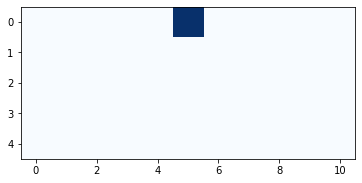

In [267]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [268]:
def step(array, i):
    """Compute row i of a CA.
    """
    rows, cols = array.shape
    row = array[i-1]
    for j in range(1, cols):
        elts = row[j-1:j+2]
        array[i, j] = sum(elts) % 2

Here's the second row.

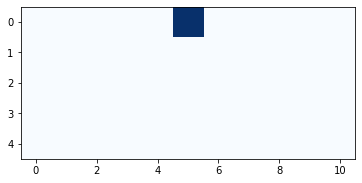

In [269]:
step(array, 4)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

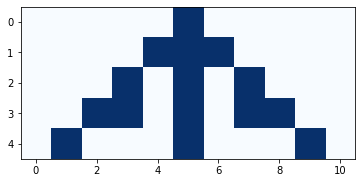

In [270]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

## Cross correlation

We can update the CA more quickly using "cross correlation".  The cross correlation of an array, `a`, with a window, `w`, is a new array, `c`, where element `k` is:

$ c_k = \sum_{n=0}^{N-1} a_{n+k} \cdot w_n $

In Python, we can compute element `k` like this:

In [271]:
def c_k(a, w, k):
    """Compute element k of the cross correlation of a and w.
    """
    N = len(w)
    return sum(a[k:k+N] * w)

To see how this works, I'll create an array:

In [272]:
N = 10
row = np.arange(N, dtype=np.uint8)
print(row)

[0 1 2 3 4 5 6 7 8 9]


And a window:

In [273]:
window = [1, 1, 1]
wind = np.array(window) 
print(wind)
print(wind * np.array([1,2,3]))
np.correlate(row, window, mode='full')


[1 1 1]
[1 2 3]


array([ 0,  1,  3,  6,  9, 12, 15, 18, 21, 24, 17,  9])

With this window, each element of `c` is the sum of three neighbors in the array:

In [274]:
c_k(row, window, 0)

3

In [275]:
c_k(row, window, 3)

12

The following function computes the elements of `c` for all values of `k` where the window can overlap with the array:

In [276]:
def correlate(row, window):
    """Compute the cross correlation of a and w.
    """
    cols = len(row)
    N = len(window)
    c = [c_k(row, window, k) for k in range(cols-N+1)]
    return np.array(c)

In [277]:
c = correlate(row, window)
print(c)

[ 3  6  9 12 15 18 21 24]


This operation is useful in many domains, so libraries like NumPy usually provide an implementation.  Here's the version from NumPy.

In [278]:
c = np.correlate(row, window, mode='valid')


In [279]:
window = [5, 1, 9]
c = np.correlate(row, window, mode='same')


**Exercise 1**

In [280]:
# Hint: use np.pad to add zeros at the beginning and end of `row`
def same_c_k(a, w, k):
    N = len(w)
    w = np.array(w)
    apad = np.pad(a,1, 'constant')
    return sum(apad[k:k+N] * w)

def same_correlate(a,w):
    c = np.array([same_c_k(row,window,i) for i in range(len(a))])
    return c

def wrap_c_k(a, w, k):
    N = len(w)
    w = np.array(w)
    apad = np.pad(a,1, 'wrap')
    return sum(apad[k:k+N] * w)

def wrap_correlate(a,w):
    c = np.array([same_c_k(row,window,i) for i in range(len(a))])
    return c

wrap = wrap_correlate(row,window)
pad = same_correlate(row,window)

print(wrap == pad) ## the padded array and the wrapped array produce the same result;
print(wrap)


[ True  True  True  True  True  True  True  True  True  True]
[  9  19  34  49  64  79  94 109 124  49]


In [281]:
# Solution goes here

## Update with correlate

Now we can use `np.correlate` to update the array.  I'll start again with an array that contains one column for each cell and one row for each time step, and I'll initialize the first row with a single "on" cell in the middle:

In [282]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Now here's a version of `step` that uses `np.correlate`

In [283]:
def step2(array, i, window=[1,1,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = c % 2

And the result is the same.

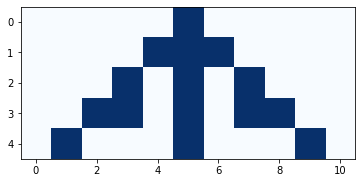

In [284]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

In [285]:
def make_table(rule):
    """Make the table for a given CA rule.
    
    rule: int 0-255
    
    returns: array of 8 0s and 1s
    """
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table

**Exercise 2 & 3**

In [286]:
def make_my_table(n):
  binar = []
  n = n%256
  for i in range(8):
    if n >= 2**(8-(i+1)):
      n = n-2**(8-(i+1))
      binar.append(1)
    else:
      binar.append(0)

  return list(reversed(binar))

print(make_my_table(10001))


def random_pattern(n,p):
  pattern = [] #I took this way of getting a random number from the graph lab
  for i in range(n):
    if random.random() > p:
      pattern.append(0)
    else:
      pattern.append(1)
  
  return np.array(pattern)

print(random_pattern(10,1))
table = make_table(10001)


[1, 0, 0, 0, 1, 0, 0, 0]
[1 1 1 1 1 1 1 1 1 1]


In [287]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self):
        """Start with random values in the top row."""
        self.array[0] = np.random.random(self.m).round()
        self.next += 1

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        # TODO: Check string length
        self.array[0] = np.array([int(x) for x in s])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

**Exercise 4**

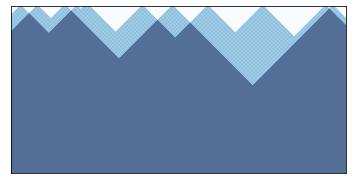

In [288]:
def draw_ca(rule,p = None, n=32):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    
    ca = Cell1D(rule, n)
    if p == None:
      ca.start_single()
    else:
      ca.start_string(random_pattern(n*2+1, p))
    ca.loop(n-1)
    ca.draw()

draw_ca(250, 0.025, 250) # I could not figure out how to work matplot lib's subplots





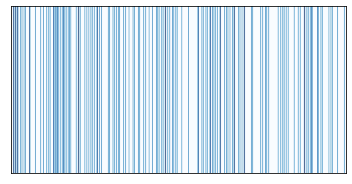

In [289]:
draw_ca(76, 0.3, 250)

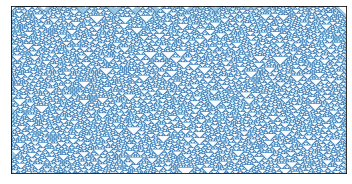

In [290]:
draw_ca(122, 0.3, 250)

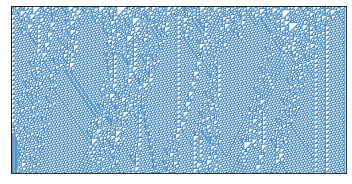

In [291]:
draw_ca(110, 0.3, 250)